In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import string
import gensim

C:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
C:\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import math
import collections

In [3]:
#Enable eager execution since this code is experimental
tf.enable_eager_execution()
tfe = tf.contrib.eager

In [146]:
table = str.maketrans('/', ' ', '!"#$%&\'()*+,-.:;<=>?@[\\]^_`{|}~' + "0123456789")
table2 = str.maketrans('/', ' ')
stopWords = []
dataset = []
maxSentLen = 0
avgSentLen = 0
missingVectors = {}

In [5]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [147]:
with open('stopwords.txt') as file:
    for line in file:
        line = line.lower()
        stopWords.append(line.strip())

In [148]:
def preprocess(text, aspectTerm=None):
    text = text.replace("[comma]", "")
    gw = lambda w: w.lower() if w in aspectTerm else w.translate(table).lower()
    if aspectTerm:
        text = [gw(word) for word in text.split() 
                if len(word) > 1 and (word in aspectTerm or word.translate(table).lower() not in stopWords)]        
    else:
        text = [word.lower() for word in text.translate(table2).split() if len(word) > 1]
    return text

In [ ]:
# should $numbers be removed ? 

In [149]:
length = 0
ll = []
with open('data-1_train.csv') as file:
    file.readline()
    for line in file:
        data = line.split(",")
        data[2] = preprocess(data[2])
        data[1] = preprocess(data[1], data[2])
        data[-1] = data[-1].strip()
        length += len(data[1])
        ll.append(len(data[1]))
        if len(data[1]) > maxSentLen:
            maxSentLen = len(data[1])
        dataset.append(data)
avgSentLen = length / len(dataset)

In [150]:
print(maxSentLen, avgSentLen)
print(sorted(ll)[int(len(ll)/2)])

33 8.113705144833549
7


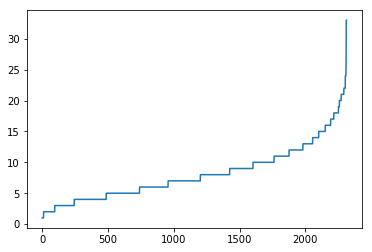

In [198]:
plt.plot(range(len(ll)), sorted(ll))
plt.show()

In [151]:
maxSentLen = 15

In [152]:
weD = 300
wvD = 2*weD

In [153]:
def train(data, label):
    inputs = keras.layers.Input(shape=(maxSentLen, wvD, 1))
    #print(inputs.shape)

    #layer<num>_<filtersize>
    conv_layer1_2 = keras.layers.Conv2D(200, (3, wvD), 1, padding='valid', activation=tf.nn.relu)(inputs)
    #print(conv_layer1_2.shape)
    pool_layer1_2 = keras.layers.MaxPool2D((maxSentLen-3+1, 1), strides=1, padding="valid")(conv_layer1_2)
    #print(pool_layer1_2.shape)

    conv_layer1_3 = keras.layers.Conv2D(200, (4, wvD), 1, padding='valid', activation=tf.nn.relu)(inputs)
    #print(conv_layer1_3.shape)
    pool_layer1_3 = keras.layers.MaxPool2D((maxSentLen-4+1, 1), strides=1, padding="valid")(conv_layer1_3)
    #print(pool_layer1_3.shape)

    conv_layer1_4 = keras.layers.Conv2D(200, (5, wvD), 1, padding='valid', activation=tf.nn.relu)(inputs)
    #print(conv_layer1_4.shape)
    pool_layer1_4 = keras.layers.MaxPool2D((maxSentLen-5+1, 1), strides=1, padding="valid")(conv_layer1_4)
    #print(pool_layer1_4.shape)

    layer1 = keras.layers.concatenate([pool_layer1_2, pool_layer1_3, pool_layer1_4], axis=1)
    #print(layer1.shape)
    layer1 = keras.layers.Flatten()(layer1)
    #print(layer1.shape)
    
    dropout = keras.layers.Dropout(0.5)(layer1)
    
    out = keras.layers.Dense(3, activation=tf.nn.softmax, kernel_regularizer=keras.regularizers.l2(0.01))(dropout)
    #print(out.shape)

    nnModel = keras.models.Model(inputs=inputs, outputs=out)
    nnModel.compile(optimizer=tf.train.AdamOptimizer(), loss='categorical_crossentropy', metrics=['accuracy'])
    #data = np.array([[word2vec['computer'].reshape(300, 1), word2vec['good'].reshape(300, 1), word2vec['screen'].reshape(300, 1), word2vec['bad'].reshape(300, 1), word2vec['keyboard'].reshape(300, 1)]])
    #print("data=", data.shape)
    #label = np.array([[1.0, 0.0, 0.0]])
    #print("label=", label.shape)
    nnModel.fit(data, label, epochs=5)
    return nnModel

In [154]:
X1 = []
y = []
yForSk = []

In [155]:
for data in dataset:
    data1 = []
    meanAspVec = None
    
    #if more than one word in aspect term, take mean
    mean = np.zeros((weD, 1))
    for w in data[2]:
        twv = None
        try:
            if w in missingVectors:
                twv = missingVectors[w]
            else:
                twv = word2vec[w].reshape(weD, 1)
        except KeyError:
            twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
            missingVectors[w] = twv
        mean += twv
    meanAspVec = mean/len(data[2])
    
    E = []
    
#     for wv in data1:
#         E.append(np.dot(wv.T, meanAspVec)/(np.linalg.norm(wv)) * np.linalg.norm(meanAspVec))
    
#     E = np.array(E).reshape(300, 1)
#     A = np.exp(E) / np.sum(np.exp(E))

    for w in data[1]:
        twv = None
        try:
            if w in missingVectors:
                twv = missingVectors[w]
            else:
                twv = word2vec[w].reshape(weD, 1)
        except KeyError:
            twv = np.random.normal(size=(weD, 1))/math.sqrt(weD+1)
            missingVectors[w] = twv
        E.append(np.dot(twv.T, meanAspVec) / (np.linalg.norm(twv) * np.linalg.norm(meanAspVec)))

    A = np.exp(E) / np.sum(np.exp(E)) # softmax

    for i, w in enumerate(data[1]):
        twv = None
        if w in missingVectors:
            twv = missingVectors[w]
        else:
            twv = word2vec[w].reshape(weD, 1)
        data1.append(np.vstack((twv, A[i] * twv)))

#     for w in data[1]:
#         twv = None
#         try:
#             if w in missingVectors:
#                 twv = missingVectors[w]
#             else:
#                 twv = word2vec[w].reshape(300, 1)
#         except KeyError:
#             twv = np.random.normal(size=(300, 1))/math.sqrt(301)
#             missingVectors[w] = twv
            
#         data1.append(np.vstack((twv, meanAspVec)))
    
    if len(data1) < maxSentLen:
        j = len(data1) + 1
        while j <= maxSentLen:
            #data1.append(np.vstack((word2vec['#'].reshape(300, 1), meanAspVec)))
            #data1.append(np.vstack((np.zeros((300, 1)), meanAspVec)))
            data1.append(np.zeros((wvD, 1)))
            j += 1
    
    if len(data1) > maxSentLen:
        del data1[maxSentLen:]
    
    X1.append(np.array(data1))
    yForSk.append(data[-1])
    if data[-1] == '-1':
        y.append(np.array([[0.0, 0.0, 1.0]]))
    elif data[-1] == '0':
        y.append(np.array([[0.0, 1.0, 0.0]]))
    elif data[-1] == '1':
        y.append(np.array([[1.0, 0.0, 0.0]]))

X1 = np.array(X1)
y = np.array(y)

In [156]:
X1.shape

(2313, 15, 600, 1)

In [157]:
y.shape

(2313, 1, 3)

In [158]:
np.shape(yForSk)

(2313,)

In [159]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

In [160]:
accuracies = []
precisions = []
recalls = []
f1s = []

for index, (train_ind, test_ind) in enumerate(kf.split(X1, yForSk)):
    print("Fold -", index)
    xtrain, xtest = X1[train_ind], X1[test_ind]
    ytrain, ytest = y[train_ind], y[test_ind]
    
    model = train(xtrain, ytrain)
    
    predictions = model.predict(xtest)
    
    y_pred = tf.argmax(predictions, dimension=1)
    y_test = tf.argmax(ytest.reshape(len(ytest), 3), dimension=1)
    
    print("Labels=", np.unique(y_test, return_counts=True))
    print("Predictions=", np.unique(y_pred, return_counts=True))
    
    cm = confusion_matrix(y_test, y_pred)
    numer = np.diag(cm)
    numer = numer.astype(np.float64)
    deno = np.sum(cm, axis = 1, dtype=np.float64)
    recall = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
    deno = np.sum(cm, axis = 0, dtype=np.float64)
    precision = np.divide(numer, deno, out=np.zeros_like(numer), where=deno!=0)
    #loss, acc = model.evaluate(xtest, ytest)
    nnum = (precision*recall)
    ddeno = (precision+recall)
    f1 = 2*np.divide(nnum, ddeno, out=np.zeros_like(nnum), where=ddeno!=0)
    acc = np.sum(numer)/np.sum(deno)
    
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    print("accuracy=", acc, "precision=", precision, "recall=", recall, "F1 Score=", f1)


Fold - 0
Epoch 1/5
66/66 [==============================] - 13s 194ms/step - loss: 11.3081 - acc: 0.3954
Epoch 2/5
66/66 [==============================] - 13s 192ms/step - loss: 11.0985 - acc: 0.4194
Epoch 3/5
66/66 [==============================] - 13s 191ms/step - loss: 11.0746 - acc: 0.4243
Epoch 4/5
66/66 [==============================] - 13s 192ms/step - loss: 11.0616 - acc: 0.4226
Epoch 5/5
66/66 [==============================] - 13s 192ms/step - loss: 11.0211 - acc: 0.4424
Labels= (array([0, 1, 2], dtype=int64), array([99, 46, 87], dtype=int64))
Predictions= (array([0, 1, 2], dtype=int64), array([182,   1,  49], dtype=int64))
accuracy= 0.5043103448275862 precision= [0.48351648 1.         0.57142857] recall= [0.88888889 0.02173913 0.32183908] F1 Score= [0.62633452 0.04255319 0.41176471]
Fold - 1
Epoch 1/5
66/66 [==============================] - 13s 195ms/step - loss: 11.2342 - acc: 0.3968
Epoch 2/5
66/66 [==============================] - 13s 201ms/step - loss: 11.1412 - acc

In [161]:
print("Average Scores:")
print("Avg. accuracy=", np.sum(accuracies)/len(accuracies))
print("Avg. precision=", np.sum(precisions, axis=0)/len(precisions))
print("Avg. recall=", np.sum(recalls, axis=0)/len(recalls))
print("Avg. f1=", np.sum(f1s, axis=0)/len(f1s))

Average Scores:
Avg. accuracy= 0.4534961253139664
Avg. precision= [0.45677804 0.1        0.47185003]
Avg. recall= [0.87365492 0.00217391 0.21495589]
Avg. f1= [0.58609144 0.00425532 0.22898606]


In [269]:
cm

array([[120,   0,  78],
       [ 59,   0,  33],
       [ 83,   0,  91]])

In [234]:
pred = tf.one_hot(tf.argmax(predictions, dimension=1), depth=3)

In [242]:
pred.shape

TensorShape([Dimension(579), Dimension(3)])

In [114]:
#word2vec['#']#.reshape(300, 1) #numpy array
#print(word2vec.similarity('computer', 'laptop'))
#np.zeros(300).shape
#word2vec.distances(word2vec['computer'], other_words=["laptop"])
word2vec["i5"]

array([ 0.16894531, -0.0480957 , -0.0480957 ,  0.265625  ,  0.02832031,
        0.05297852,  0.04370117,  0.28125   ,  0.14160156,  0.32421875,
       -0.04931641,  0.02514648,  0.10742188, -0.28515625,  0.19921875,
        0.28320312,  0.11132812, -0.09619141, -0.02990723, -0.18457031,
       -0.18457031,  0.08203125,  0.09863281,  0.1015625 ,  0.05737305,
       -0.05981445, -0.1875    ,  0.34570312, -0.15234375, -0.21289062,
        0.20019531,  0.3125    ,  0.03271484, -0.04882812, -0.16992188,
       -0.3046875 , -0.14648438,  0.19238281,  0.13378906,  0.28710938,
        0.21875   ,  0.26367188,  0.30273438, -0.04614258, -0.12695312,
       -0.05615234,  0.10595703, -0.453125  , -0.13476562,  0.09423828,
       -0.03833008, -0.16308594, -0.25      ,  0.08935547, -0.07958984,
        0.26171875,  0.20703125,  0.02941895,  0.0534668 ,  0.140625  ,
        0.08886719,  0.19335938, -0.21875   ,  0.14160156,  0.1953125 ,
       -0.20996094,  0.05712891,  0.24511719, -0.27148438,  0.17